In [44]:
import torch
import numpy as np
import os
import pandas as pd
import random
from tqdm import tqdm

random.seed(42)

In [45]:
data_dir = '../osic-pulmonary-fibrosis-progression'

In [46]:
from preprocess import preprocess_scans
import pickle

if not os.path.exists(f'{data_dir}/preprocessed_scans.pkl'):
    preprocessed_scans = preprocess_scans(data_dir)
    pickle.dump(preprocessed_scans, open(f'{data_dir}/preprocessed_scans.pkl', 'wb'))

In [47]:
# Input: List of patient_id
# Output: Tuple of (train_patient_ids, val_patient_ids)
# train_ratio: Ratio of training set
def train_val_split(patients: pd.DataFrame, train_ratio: float = 0.8) -> (pd.DataFrame, pd.DataFrame):
  patient_ids = patients['Patient'].unique()
  random.shuffle(patient_ids)

  train_patients = patients[patients['Patient'].isin(patient_ids[:int(len(patient_ids) * train_ratio)])]
  val_patients = patients[patients['Patient'].isin(patient_ids[int(len(patient_ids) * train_ratio):])]

  return train_patients, val_patients

In [48]:
# Prepare train and val data
train_datas = pd.read_csv(data_dir + '/train.csv')
test_datas = pd.read_csv(data_dir + '/test.csv')

# Remove row in train data if patient_id is in test_patient_ids
train_datas = train_datas[~train_datas['Patient'].isin(test_datas)]

# Sort df by patient and then by 'Weeks'
train_datas = train_datas.sort_values(by=['Patient', 'Weeks'])

# Group by patient and get the first FVC value and weeks
patient_id_to_initial_FVC = train_datas.groupby('Patient')['FVC'].first().to_dict()
patient_id_to_initial_weeks = train_datas.groupby('Patient')['Weeks'].first().to_dict()

train_datas, val_datas = train_val_split(train_datas)

# Count the number of scans for each patient
scan_count = {}
for patient_id in os.listdir(os.path.join(data_dir, 'train')):
    scan_count[patient_id] = len(os.listdir(os.path.join(data_dir, 'train', patient_id)))


In [49]:
from collections import defaultdict

train_x, train_y = defaultdict(list), defaultdict(list)

for idx, row in train_datas.iterrows():
    train_x[row['Patient']].append({
        'Weeks': row['Weeks'],
        'initial_FVC': patient_id_to_initial_FVC[row['Patient']],
        'initial_weeks': patient_id_to_initial_weeks[row['Patient']],
    })
    train_y[row['Patient']].append(row['FVC'])

val_x, val_y = defaultdict(list), defaultdict(list)

for idx, row in val_datas.iterrows():
    val_x[row['Patient']].append({
        'Weeks': row['Weeks'],
        'initial_FVC': patient_id_to_initial_FVC[row['Patient']],
        'initial_weeks': patient_id_to_initial_weeks[row['Patient']],
    })
    val_y[row['Patient']].append(row['FVC'])

In [50]:
from torch import nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, input_dim=256):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, scans: torch.Tensor):
        # Scans: List of num_slices, 1, 256, 256
        x = F.relu(self.conv1(scans))
        x = self.pool(x) # num_slices, 32, 128, 128
    
        x = F.relu(self.conv2(x))
        x = self.pool(x) # num_slices, 64, 64, 64
        
        x = F.relu(self.conv3(x))
        x = self.pool(x) # num_slices, 128, 32, 32

        x = F.relu(self.conv4(x))
        x = self.pool(x) # num_slices, 256, 16, 16

        x = F.relu(self.conv5(x))
        x = self.pool(x) # num_slices, 512, 8, 8

        # x = self.global_pool(x) # num_slices, 512, 1, 1

        return x

class FCLayer(nn.Module):
    def __init__(self, input_dim=512*8*8+3):
        super(FCLayer, self).__init__()
        self.fc1 = nn.Linear(input_dim, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 1)

    def forward(self, features, weeks, initial_FVC, initial_FVC_weeks):
        x = torch.cat([features, weeks, initial_FVC, initial_FVC_weeks])
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [53]:
from torch import nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, input_dim=256):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, scans: torch.Tensor):
        # Scans: List of num_slices, 1, 256, 256
        x = F.relu(self.conv1(scans))
        x = nn.MaxPool2d(2, 2)(x) # num_slices, 64, 128, 128

        x = self.conv2(x) # num_slices, 64, 64, 64
        x = self.conv3(x) # num_slices, 128, 32, 32
        x = self.conv4(x) # num_slices, 256, 16, 16
        x = self.conv5(x) # num_slices, 512, 8, 8
    
        x = self.global_pool(x) # num_slices, 512, 1, 1
        x = x.view(1, 512)

        return x

class FCLayer(nn.Module):
    def __init__(self, input_dim=512+3):
        super(FCLayer, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, features, weeks, initial_FVC, initial_FVC_weeks):
        x = torch.cat([features, weeks, initial_FVC, initial_FVC_weeks])
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [69]:
from datetime import datetime

from preprocess import get_preprocessed_scan

# Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

cnn_model = CNN()
cnn_model.to(device)

fc_model = FCLayer()
fc_model.to(device)

epoch = 6
batch_size = 256

training_loss = []
val_loss = []

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    list(cnn_model.parameters()) + list(fc_model.parameters()), lr=0.002
)

log_file = 'training_log.txt'
with open(log_file, 'w') as f:
    f.write(f"Training started: {datetime.now()}\n")
    f.write("="*70 + "\n\n")

for epoch in range(epoch):
    with open(log_file, "a") as f:
        f.write(f"Epoch {epoch}\n")
    cnn_model.train()
    fc_model.train()

    patient_count = 0
    accum_loss = 0
    for patient_id in tqdm(train_x.keys()):
        if patient_count % 8 == 0:
            optimizer.zero_grad()
            accum_loss = 0

        patient_scan_count = scan_count[patient_id]
        features = torch.tensor([], dtype=torch.float32, device=device)
        for i in range(1, patient_scan_count + 1, batch_size):
            scans = []
            for j in range(i, min(i+batch_size, patient_scan_count + 1)):
                scan = get_preprocessed_scan(data_dir, patient_id, j)
                if scan is None:
                    continue
            scan = torch.tensor(scan, dtype=torch.float32, device=device)
            scans.append(scan)
            scans = torch.stack(scans)
        
            batch_scans = scans
            features = torch.cat([features, cnn_model.forward(batch_scans)])
        
        features = torch.mean(features, dim=0) # 1024,
        
        x = train_x[patient_id]
        y = train_y[patient_id]

        # Accumulate for all datapoints of patient
        for i in range(len(x)):
            weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
            initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
            initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

            # Forward Pass
            output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
            loss = criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device))

            # accumulate gradient
            loss.backward(retain_graph=True)
            accum_loss += loss.item()

        # Update parameters based on batch of 8 patients
        if patient_count % 8 == 7:
            optimizer.step()
        patient_count += 1
        
        with open(log_file, "a") as f:
            f.write(f"Epoch {epoch}, Loss: {accum_loss / max(len(x), 1)}\n")
        if len(x) == 0:
            print(f"Patient {patient_id} has no data during training")
        training_loss.append(accum_loss / max(len(x), 1))
    
        del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output, loss
        torch.cuda.empty_cache()

    # Validation
    with torch.no_grad():
        for patient_id in tqdm(val_x.keys()):
            optimizer.zero_grad()

            patient_scan_count = scan_count[patient_id]
            features = torch.tensor([], dtype=torch.float32, device=device)
            for i in range(1, patient_scan_count + 1, batch_size):
                scans = []
                for j in range(i, min(i+batch_size, patient_scan_count + 1)):
                    scan = get_preprocessed_scan(data_dir, patient_id, j)
                    if scan is None:
                        continue
                scan = torch.tensor(scan, dtype=torch.float32, device=device)
                scans.append(scan)
                scans = torch.stack(scans)
            
                batch_scans = scans
                features = torch.cat([features, cnn_model.forward(batch_scans)])
            
            features = torch.mean(features, dim=0) # 1024,
            
            x = val_x[patient_id]
            y = val_y[patient_id]

            # Accumulate for all datapoints of patient
            accum_loss = 0
            for i in range(len(x)):
                weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
                initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
                initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

                # Forward Pass
                output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
                loss = criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device))
                accum_loss += loss.item()

            with open(log_file, "a") as f:
                f.write(f"Epoch {epoch}, Val Loss: {accum_loss / max(len(x), 1)}\n")
            val_loss.append(accum_loss / max(len(x), 1))

            if len(x) == 0:
                print(f"Patient {patient_id} has no data during validation")

            del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output, loss
            torch.cuda.empty_cache()

 13%|█▎        | 18/140 [00:01<00:11, 10.19it/s]

Redoing work
Error reading ../osic-pulmonary-fibrosis-progression\train\ID00052637202186188008618\4.dcm: Unable to decompress 'JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])' pixel data because all plugins are missing dependencies:
	gdcm - requires gdcm>=3.0.10
	pylibjpeg - requires pylibjpeg>=2.0 and pylibjpeg-libjpeg>=2.1


 14%|█▎        | 19/140 [00:01<00:10, 11.20it/s]

Redoing work
Error reading ../osic-pulmonary-fibrosis-progression\train\ID00052637202186188008618\4.dcm: Unable to decompress 'JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])' pixel data because all plugins are missing dependencies:
	gdcm - requires gdcm>=3.0.10
	pylibjpeg - requires pylibjpeg>=2.0 and pylibjpeg-libjpeg>=2.1


 14%|█▎        | 19/140 [00:01<00:11, 10.99it/s]

Redoing work
Error reading ../osic-pulmonary-fibrosis-progression\train\ID00052637202186188008618\4.dcm: Unable to decompress 'JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])' pixel data because all plugins are missing dependencies:
	gdcm - requires gdcm>=3.0.10
	pylibjpeg - requires pylibjpeg>=2.0 and pylibjpeg-libjpeg>=2.1


 14%|█▎        | 19/140 [00:01<00:10, 11.54it/s]

Redoing work
Error reading ../osic-pulmonary-fibrosis-progression\train\ID00052637202186188008618\4.dcm: Unable to decompress 'JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])' pixel data because all plugins are missing dependencies:
	gdcm - requires gdcm>=3.0.10
	pylibjpeg - requires pylibjpeg>=2.0 and pylibjpeg-libjpeg>=2.1


 14%|█▎        | 19/140 [00:01<00:10, 11.14it/s]

Redoing work
Error reading ../osic-pulmonary-fibrosis-progression\train\ID00052637202186188008618\4.dcm: Unable to decompress 'JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])' pixel data because all plugins are missing dependencies:
	gdcm - requires gdcm>=3.0.10
	pylibjpeg - requires pylibjpeg>=2.0 and pylibjpeg-libjpeg>=2.1


 14%|█▎        | 19/140 [00:01<00:10, 11.47it/s]

Redoing work
Error reading ../osic-pulmonary-fibrosis-progression\train\ID00052637202186188008618\4.dcm: Unable to decompress 'JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])' pixel data because all plugins are missing dependencies:
	gdcm - requires gdcm>=3.0.10
	pylibjpeg - requires pylibjpeg>=2.0 and pylibjpeg-libjpeg>=2.1


100%|██████████| 36/36 [00:01<00:00, 22.66it/s]


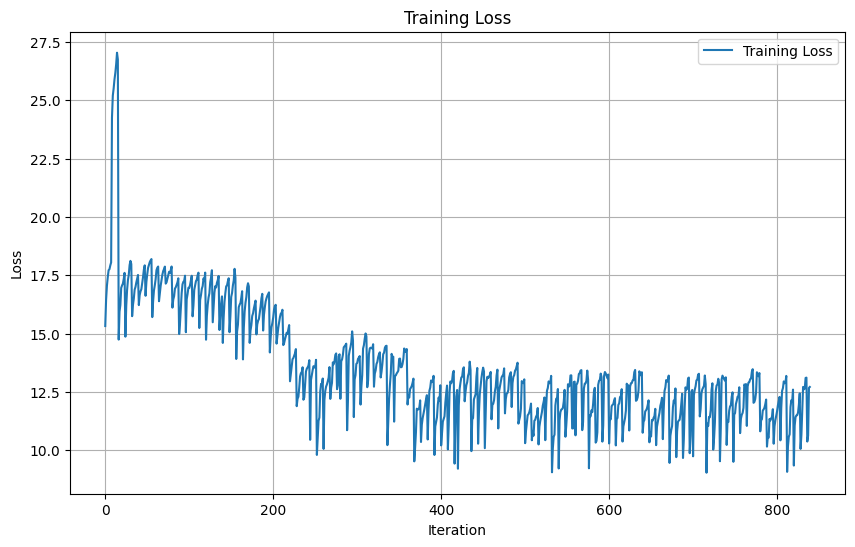

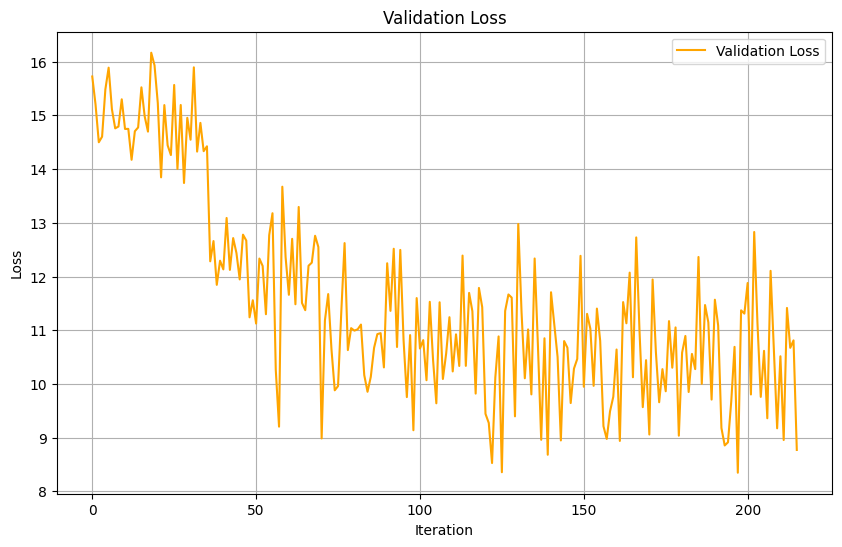

In [71]:
import matplotlib.pyplot as plt
import math

plt.figure(figsize=(10, 6))
plt.plot(range(len(training_loss)), [math.log(x) for x in training_loss], label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(len(val_loss)), [math.log(x) for x in val_loss], label='Validation Loss', color='orange')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from preprocess import get_test_preprocessed_scan

cnn_model.eval()
fc_model.eval()

test_datas = pd.read_csv(data_dir + '/test.csv')

test_x = defaultdict(list)
test_y = defaultdict(list)

for idx, row in test_datas.iterrows():
    test_x[row['Patient']].append({
        'Weeks': row['Weeks'],
        'initial_FVC': patient_id_to_initial_FVC[row['Patient']],
        'initial_weeks': patient_id_to_initial_weeks[row['Patient']],
    })
    test_y[row['Patient']].append(row['FVC'])

test_predictions = []

for patient_id in tqdm(test_x.keys()):
    patient_scan_count = scan_count[patient_id]
    features = torch.tensor([], dtype=torch.float32, device=device)
    for i in range(1, patient_scan_count + 1, batch_size):
        scans = []
        for j in range(i, min(i+batch_size, patient_scan_count + 1)):
            scan = get_test_preprocessed_scan(data_dir, patient_id, j)
            if scan is None:
                continue
        scan = torch.tensor(scan, dtype=torch.float32, device=device)
        scans.append(scan)
        scans = torch.stack(scans)

